# Model NEATM 余亮亮 修改 $\alpha, \phi$
$D_{eff}=\frac{1329\times10^{-H_v/5}}{\sqrt{p_v}}$
$p_v=\frac{A_B}{q}$
$q_s=\frac{F_{sun}}{d^2}$
$T_{fit}=[\frac{(1-A)F_{sun}}{\eta\epsilon\sigma d}]^{1/4}$
$T=T(\theta,\phi)=T_{fit}\cos^{1/4}\theta\cos^{1/4}\phi,(-\frac{\pi}{2}<\theta<\frac{\pi}{2},-\frac{\pi}{2}<\phi<\frac{\pi}{2})$
$F_\lambda=F(\Delta,d,\alpha|\eta,D)$

$F_\lambda=\frac{\epsilon D^2}{2\Delta ^2}\frac{\pi h c^2}{\lambda ^5}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\alpha+\pi/2}\frac{1}{exp(\frac{hc}{\lambda kT(\theta,\phi)}-1)}\cos^2 \phi\cos(\alpha-\theta)d\theta$


# MCMC_NEATM
## import & define const

In [1]:
#import
import numpy as np
import matplotlib.pyplot as plt
import math as mh 

#constant
Fsun = 1367.5           # sun constant
sigma = 5.67E-8         #stefan-boltzmann constant
h = 6.626007015E-34     #plank constant
#q = 0.29+0.684*0.15    #phase integral = 0.29+0.684*G(=0.15)
epsi = 0.9              #radiance epsilon
kB = 1.38064852E-23     #boltzmann constant  j/k
cl = 299792458.0        #lightspeed m/s
au = 149597870700.0
pi = 3.1415926535
eta_guess = [1.2,0.7]
D_guess = [400,200000]
logf_guess = [1,0.1,1]
eta_piror = [0.5,2.8]
D_piror = [0,2500000]
Hv = 20
G = 0.15
Ndd = 10
lamdai = [12,22]

## define MODEL FUNCTION
initial x:flux = delta, it will change "delta"!
list: a,b
a = b
a = b[:]

### Model_hhq

In [2]:
def neatm_ohhq(Ndd,eta,D,delta,dd,alpha,lamda,A):   
    summ = 0.
    a = alpha-pi/2
    b = pi/2
    c = -pi/2          
    d = pi/2
    Tfit = np.power((1-A)*Fsun/(eta*epsi*sigma*dd*dd),0.25)
    #print(f"Tss = {Tfit}\n")
    dxdy = ((b-a)*(d-c)/(Ndd*Ndd)) 
    for j in range(Ndd):
        for i in range(Ndd):
            phii = (c+(d-c)*j/Ndd)
            thei = (a+(b-a)*i/Ndd)
            T = Tfit*np.power(np.cos(thei),0.25)*np.power(np.cos(phii),0.25)
            #print(f"Tss = {T-273}\n")
            integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
            summ = summ + dxdy*integral
    #print('hhq',delta)
    F = (epsi*np.power(D,2)*pi*h*cl*cl)*summ/(2*np.power(delta*au,2)*np.power(lamda,5))

    F = F*(lamda)**2/cl*1e29
    #print('hhq2',delta)
    return F
def Model_neatm_ohhq(theta,x,lamda):
    eta,D = theta
    
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    #print("neatm ",delta)
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial flux
    flux = np.zeros(len(delta))
    nn = int(len(flux))
    for i in range(0,(int(nn/2))-1):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda1*1e-6,A)
    for i in range(int(nn/2),nn):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda2*1e-6,A)
        #print("neatm",i,'=',delta[i])
    #print('2',delta)
    return flux

### Model_jhx

In [3]:
#constants---------------------------------------------------------------------------
#emissivity:
epsi = 0.9
#stefan-boltzman:
sigmas = 5.67*10**(-8)
#solar constant:
f_solar = 1367.5
#planck constant:
h = 6.62607015 * 10 ** (-34)
#speed of light
c = 3.0 * 10 ** 8 
#boltzmann constant
kb = 1.380649 * 10 ** (-23)
#astronomical unit in unit of meter
au = 1.496 * 10 ** 11
def neatm_jhx(Ndd,dast,dao,alpha,Dia,wlenth,yita,A):
    #dast: distance from asteroid to Sun :d
    #dobs: distance from observer to Sun  :dd
    #dao:  distance from asteroid to observer :delta
    #alpha: solar phase
    #dia: diameter of asteroid
    #wlenth: wavelength
    #yita: beaming parameter
    #A: bond albedo
	
	T_ss = ((1 - A) * f_solar / epsi / yita / sigmas / dast ** 2) ** 0.25
	Nd = int(Ndd);#print(f'nd={Nd}')
	phi = np.zeros((Nd-1,1))
	theta = np.zeros((Nd-1,1))
	for i in range(0,Nd-1):#phi , theta is the angle from subsolar point
			phi[i] = -pi/2.0 + i * pi / Nd
			theta[i] = alpha-pi/2.0 + i * pi / Nd
	#nj = np.floor(((alpha - pi / 2.0) + pi / 2.0) / (pi / Nd)) 
	dphi, dtheta = (pi)/Nd,pi/Nd;#print(f'phi={phi};the={theta}')
	ss = dphi*dtheta;#print(f'ss={ss}')#dtheta*dphi
	wlenth = wlenth * 10 ** (-6)
	temp = np.zeros((len(phi),len(theta)))
	flux = 0.0
	flux_con = epsi * Dia ** 2 * pi  * h * c ** 2  / (wlenth ** 5)
	for j in range(0,len(phi)):
		for k in range(0,len(theta)):
			temp[j,k] = T_ss * abs(np.cos(theta[k])) ** 0.25 * abs(np.cos(phi[j])) ** 0.25;#print(f'tss:{T_ss}p{phi[j]}t{theta[k]}');print(f'temp:{temp[j,k]}e={np.exp(h * c / (wlenth * kb * temp[j,k])) - 1}')
			flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 ;#print(f'f={flux}')# obtain flux in unit of mjy
	return flux
def Model_neatm_jhx(theta,x,lamda):
    eta,D =theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    nn = len(delta)
    flux = np.zeros(nn)
    for i in range(0,int(nn/2)):
        fluxi = neatm_jhx(Ndd,d[i],delta[i],alpha[i],D,lamda1,eta,A)
        if fluxi!=fluxi:fluxi = 0
        flux[i] = fluxi
    for i in range(int(nn/2),nn):
        fluxi = neatm_jhx(Ndd,d[i],delta[i],alpha[i],D,lamda2,eta,A)
        if fluxi!=fluxi:fluxi = 0
        flux[i] = fluxi
        
    #print('hello',flux)
    return flux

## read data file

/tmp/ipykernel_356039/3798247563.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_356039/3011063627.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 ;#print(f'f={flux}')# obtain flux in unit of mjy


[ 7.12627918  7.16429848  7.17851633  7.17869832  7.18682079  7.20931189
  7.21325478  7.24722761  7.9659508   8.01558698  8.04734733  8.14352707
  8.15416748  8.16411281  8.23130783  8.2644412   8.289711    8.30625405
  8.31494287  8.32091611  8.33059266  8.34528409  8.39016626  8.47435882
  8.48317118  8.48899097  8.50847977  8.5244005   8.56762426  8.58332751
  8.60891093  8.61819557  8.6332305   8.64679191  8.65219993  8.66824388
  8.67755588  8.68579787  8.70278168  8.76215243  8.77808983  8.81239345
  8.82935445  8.83698749  8.8718072   8.95970041  9.03013558  9.06378169
  9.0987076   9.0987076   0.         10.07240879 10.1266937  10.14695674
 10.14727986 10.15884587 10.19094501 10.19652645 10.24509821 11.2671233
 11.33746992 11.38241879 11.51855701 11.53363945 11.54774131 11.64281499
 11.68966171 11.72538633 11.74875638 11.76104792 11.76943985 11.78312828
 11.80386154 11.86730947 11.98617926 11.99862688 12.00679241 12.03434088
 12.05677493 12.11777848 12.13988252 12.17596844 12.

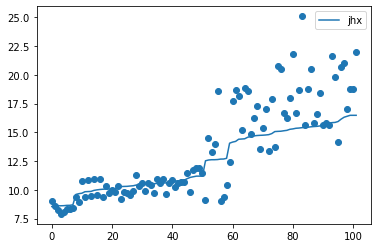

In [4]:
name = '2ev5'
obsec = np.loadtxt(f'ObsECs_{name}.txt')
#print(obsec)
obsdat = np.loadtxt(f'obs_{name}.txt')
#obstime  = np.loadtxt(f'fobs_{name}.txt')
#ast-sun
d_N = np.sqrt(obsec[:,0]**2+obsec[:,1]**2+obsec[:,2]**2)
delta_N = np.sqrt((obsec[:,3]-obsec[:,0])**2+(obsec[:,4]-obsec[:,1])**2+(obsec[:,5]-obsec[:,2])**2)
#earth-sun
#print(delta_N)
dd_N = np.sqrt(obsec[:,3]**2+obsec[:,4]**2+obsec[:,5]**2)
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
y = obsdat
nt = np.arange(len(d_N))
plt.scatter(nt,y)
#delta_N,d_N,alpha_N = x
'''for i in np.arange(100,2000,50):
    theta = [0.2,i]
    flux = Model_neatm_hhq(theta,x=(delta_N,d_N,alpha_N))
    flux2 = Model_neatm_jhx(theta,x=(delta_N,d_N,alpha_N))
    print(i,flux[0],flux2[0])
for i in np.arange(0.1,2.4,0.1):
    theta = [i,456]
    flux = Model_neatm_hhq(theta,x=(delta_N,d_N,alpha_N))
    flux2 = Model_neatm_jhx(theta,x=(delta_N,d_N,alpha_N))
    print(i,flux[0],flux2[0])'''
theta = [2.8,250]
flux = Model_neatm_ohhq(theta,x=(delta_N,d_N,alpha_N),lamda=lamdai)
flux2 = Model_neatm_jhx(theta,x=(delta_N,d_N,alpha_N),lamda=lamdai)
x = (delta_N,d_N,alpha_N)
yerr = 0.1*y
#plt.plot(nt,flux,label = 'hhq')
plt.plot(nt,flux2,label = 'jhx')

plt.legend()
print(flux)
print(y)


## define MCMC_function

In [5]:
#initial
eta_gs = 1.2
D_gs = 400
eta_gss = [0.01,5]
D_gss = [1,500000]

In [6]:
#MCMC Function
def log_likelihood(theta, x, y, yerr):
    eta,D= theta
    model = Model_neatm_ohhq(theta,x,lamdai)
    #model = eta*x[0]*100 + D
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
def log_prior(theta):
    eta,D = theta
    if eta_gss[0]< eta < eta_gss[1] and D_gss[0] < D < D_gss[1]:
        return 0.0
    return -np.inf
    #return 0
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
     #   print('hi','-inf')
        return -np.inf
    yy=lp + log_likelihood(theta, x, y, yerr)
    #print('hi',yy)
    return yy


In [7]:
#initial para guesses
eta = eta_gs
D = D_gs
theta = [eta, D]

In [8]:
import emcee
#initialize sampler
ndim, nwalkers = len(theta), 10
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
pos = [theta + 1e-6*np.random.randn(ndim) for i in range(nwalkers)]
#run mcmc
sampler.run_mcmc(pos, 1000, progress=True);

/tmp/ipykernel_356039/3798247563.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
100%|██████████| 1000/1000 [13:26<00:00,  1.24it/s]


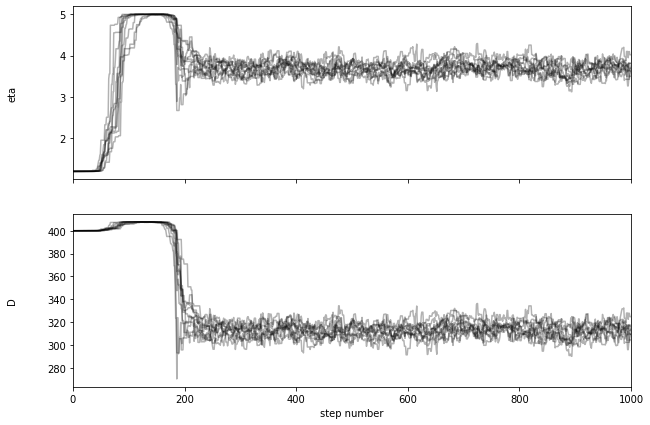

In [9]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["eta", "D"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");

(260, 2)


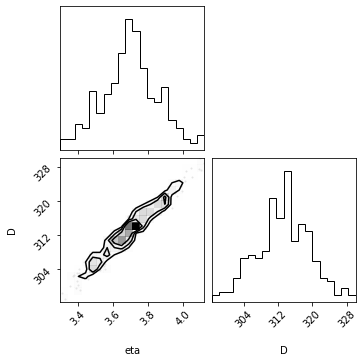

In [10]:
#--------------------------
flat_samples = sampler.get_chain(discard=600, thin=15, flat=True)
print(flat_samples.shape)
import corner
fig = corner.corner(
flat_samples, labels=labels, truths=[eta_gs, 103816]
);

In [11]:
from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    #print(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))
print(Math(txt))
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
pv = (1329*pow(10,-Hv/5)/(D_fit*0.001))**2
print('eta_gs = ',eta_gs,'D_gs= ',D_gs,'pv=',pv)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>
eta_gs =  1.2 D_gs=  400 pv= 0.17975423016177955


eta_fit =  3.7011704563591046 D_fit=  313.46237604523066 pv =  0.17975423016177955
loss =  inf


/tmp/ipykernel_356039/3798247563.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_356039/3511581315.py:7: RuntimeWarning: divide by zero encountered in true_divide
  return sum(((cal-y)/yerr)**2)/nn
/tmp/ipykernel_356039/3798247563.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_356039/3798247563.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_356039/3798247563.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_356039/3798247563.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_356039/3798247563.py:16: RuntimeWarning: ov

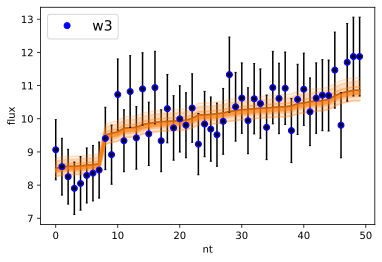

In [18]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def loss(cal,y,yerr):
    nn = len(y)
    return sum(((cal-y)/yerr)**2)/nn
eta_low,eta_fit,eta_high = np.percentile(flat_samples[:, 0], [16, 50, 84])
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
print('eta_fit = ',eta_fit,'D_fit= ',D_fit,'pv = ',(1329*pow(10,-Hv/5)/(D_fit*0.001))**2)
theta = eta_fit,D_fit

leni = len(nt)
half = int(leni/2)
yt = Model_neatm_ohhq(theta,x,lamdai)
print('loss = ',loss(yt,y,yt*0.1))
plt.plot(nt[0:half-1], yt[0:half-1],"k")

inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    #print(ind,':',sample)
    plotmodel = Model_neatm_ohhq(sample,x,lamdai)
    plt.plot(nt[0:half-1], plotmodel[0:half-1], "C1", alpha=0.1)
plt.plot(nt[0:half-1],y[0:half-1],'bo',label = 'w3')
plt.errorbar(nt[0:half-1], y[0:half-1], yerr=yerr[0:half-1], fmt=".k", capsize=1.0)
plt.legend(fontsize=14)
plt.xlabel("nt")
plt.ylabel("flux");
#plt.savefig(f'{name}_w3.pdf')

/tmp/ipykernel_356039/3798247563.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_356039/3798247563.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_356039/3798247563.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_356039/3798247563.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_356039/3798247563.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_356039/3798247563.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_356039/379824

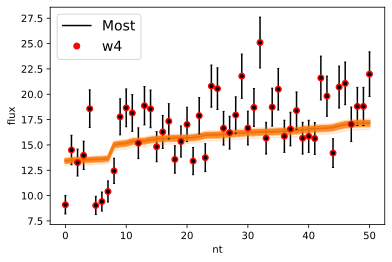

In [20]:
plt.plot(nt[0:half], yt[half:leni],"k", label="Most")

inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    #print(ind,':',sample)
    plotmodel = Model_neatm_ohhq(sample,x,lamdai)
    plt.plot(nt[0:half], plotmodel[half:leni], "C1", alpha=0.1)
plt.plot(nt[0:half],y[half:leni],'ro',label = 'w4')
plt.errorbar(nt[0:half], y[half:leni], yerr=yerr[half:leni], fmt=".k", capsize=1.0)
plt.legend(fontsize=14)
plt.xlabel("nt")
plt.ylabel("flux");
#plt.savefig(f'{name}_w4.pdf')
